# Taiwanese PERM data analysis

### What is PERM?
__[Program Electronic Review Management](https://www.foreignlaborcert.doleta.gov/perm.cfm)__ (PERM) allows employers to hire a foreign worker to work permanently in the United States. 

This process, through the U.S. Department of Labor, is vital in ensuring that the admission of foreign workers will not adversely affect job opportunities, wages or working conditions of U.S. workers.


### Why is this important?
For employers looking to fill out this petition for permanent residence for one of their employees, it is important to know the salary range for each job title/level. Petitions that meet the appropriate salary ranges are more likely to be approved. 

##### Having gone through this process, as a Taiwanese born foreigner, I analyzed the salaries for almost 9,000 petitions.



### Where does this data come from?

__[Visadoor](http://visadoor.com)__ is a U.S. Visa database of Employment Based Green Cards (PERM), H1B Visas (LCA), and Student Visas. Using Python with the urllib and the BeautifulSoup library, I scraped cases where the petition beneficiary is Taiwanese. Here are links to the __[web scraping code](https://github.com/ktc312/Visadoor-Scraper/blob/master/main.py)__ and the __[raw data file](https://drive.google.com/file/d/0B6zoHPPeANghVDdEVVFueUEwbmc/view)__.

# See __[Summary Report](http://www.ktcdata.com/tw_perm/)__

---

# Read and Clean the data

In [1]:
import pandas as pd
import numpy as np

# Data from October 2007 to March 2017
perm_df = pd.read_csv('data/TW_PERM.csv', parse_dates=['Decision_Date'])
perm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8975 entries, 0 to 8974
Data columns (total 7 columns):
id               8975 non-null object
Decision_Date    8975 non-null datetime64[ns]
Employer         8975 non-null object
City_State       8975 non-null object
Case_Status      8975 non-null object
Job_Title        8947 non-null object
Wage_Offer       8975 non-null object
dtypes: datetime64[ns](1), object(6)
memory usage: 490.9+ KB


In [2]:
perm_df = perm_df.rename(columns={'Decision_Date': 'Date', 'Case_Status': 'Status'})
perm_df.head()

,id,Date,Employer,City_State,Status,Job_Title,Wage_Offer
0,A-16146-14510,2017-02-01,Sandisk Corporation,"Milpitas, CA",Certified,"Electronics Engineers, Except Computer, Level II","122,672.00/Year"
1,A-16263-53960,2017-01-11,"Ooyala, Inc.","Santa Clara, CA",Certified,"Software Developers, Systems Software, Level II","125,000.00/Year"
2,A-16123-04570,2016-11-15,"Baily International, Inc.","HOUSTON, TX",Certified,"BUSINESS DEVELOPMENT ANALYST, Level I",37378/Year
3,A-15091-63241,2016-09-30,"Netapp, Inc.","Cranberry Township, PA",Certified,"Software Developers, Systems Software, Level II","74,568.00/Year"
4,A-16159-18555,2016-09-30,"Hauptman Ham, Llp","Alexandra, VA",Certified,"Paralegals and Legal Assistants, Level III","108,909.00/Year"


In [3]:
# clean the data, column by column

# Drop id
perm = perm_df.drop('id', axis=1)

# Employer name
original_counts = perm.Employer.str.lower().value_counts() 

display(pd.DataFrame(original_counts.head()))

print('--------------------------------')
print('Employer names need to clean up.')
print('--------------------------------')

apple = perm.loc[(perm.Employer.str.lower().str.startswith('apple')) &
                 (perm.Employer.str.lower().str.endswith('inc.'))
                ].Employer.value_counts() 

display(pd.DataFrame(apple))

,Employer
intel corporation,209
microsoft corporation,137
google inc.,77
"super micro computer, inc.",65
broadcom corporation,56


--------------------------------
Employer names need to clean up.
--------------------------------


,Employer
Apple Inc.,37
"Apple, Inc.",28
"Apple Computer, Inc.",1
Appleseed Montessori Inc.,1


In [4]:
# edit employer name to operating name of a company, as opposed to the legal name of the company (dba)

for dba in [' dba ', ' d/b/a ']:
    perm.loc[perm.Employer.str.lower().str.contains(dba), 'Employer'] = perm.Employer      \
                                                                            .str.lower()   \
                                                                            .str.split(dba)\
                                                                            .str[1]
            
           

# edit employer name to same format
edit_list = ['oracle', 'qualcomm', 'formosa plastics', 'amazon', 'tsmc',
             'texas instrument', 'nan ya plastics', 'foxconn', 'pricewaterhousecoopers',
             'world journal', 'pacpizza', 'hewlett-packard', 'muy pizza', 'ernst & young', 
             'acme furniture', 'air sea transport', 'appleseed', 'au optronics', 'bank sinopac', 
             'american future technology', 'yang ming america', 'paradigm', 'paragi']  
for name in edit_list: 
    perm.loc[perm.Employer.str.lower().str.startswith(name), 'Employer'] = name


# remove unnecessary characters
replace_list = [',', '!', '.', ' inc', ' llc', ' llp', ' ltd', ' lp', 
                ' corporation', ' corporate', ' corp', ' technologies'] 
for char in replace_list: 
    perm.Employer = perm.Employer.str.lower().str.replace(char, '')  

# edit typo
perm.Employer = perm.Employer                                                              \
                    .str.lower()                                                           \
                    .str.replace('buisness', 'business')                                   \
                    .str.replace('cisco-linksys', 'cisco systems')                         \
                    .str.replace('apple computer', 'apple')                                \
                    .str.replace('appleseed', 'appleseed international montessori school') \
                    .str.replace('sutech industry a division of foxconn', 'foxconn')       \
                    .str.replace('paradigm', 'Paradigm Health & Wellness')                 \
                    .str.replace('paragi', 'Paradigm Health & Wellness')                   \
                    .str.replace('uni pac continental', 'unipac continental')              \
                    .str.capitalize()
    
company_counts = perm.Employer.value_counts()

display(pd.DataFrame(company_counts.head()))

,Employer
Intel,209
Microsoft,137
Google,119
Qualcomm,115
Apple,66


In [5]:
# city and state, add area

# edit delimiter
perm.City_State = perm.City_State.str.replace(',,', ',')

# show some dirty city and state ones 

# edit typo
edit_list = {"Washington, Dc": "Washington, DC", "Dededo": "Dededo, GU", "Suite # 301": "Sunnyvale, CA",
             "Ny": "New York, NY", "28014": "Valencia, CA", "260": "Lexington, KY", 
             "St. Mary": "St. Mary's City, MD", "Honolulu": "Honolulu, HI", "Hushing": "Flushing, NY"}
for key, value in edit_list.items():
    perm.loc[perm.City_State.str.startswith(key),'City_State'] = value

perm['City']  = perm.City_State.str.split(', ').str[0].str.lower().str.capitalize()
perm['State'] = perm.City_State.str.split(', ').str[1].str.upper()

# using city names list to add area
# The New York Metro area and California Bay Area cities list is from wikipedia

ny_cities = pd.read_csv('data/NY_cities.csv', names=['city'])
bay_cities = pd.read_csv('data/Bay_Area_cities.csv', names=['city'])

perm.loc[(perm.State.isin(['NY', 'NJ', 'CT'])) & 
         (perm.City.str.upper().isin(ny_cities.city)), 'Area']  = 'New York Metro'
perm.loc[(perm.State.isin(['CA'])) & 
         (perm.City.str.upper().isin(bay_cities.city)), 'Area'] = 'California Bay Area'

perm = perm.drop('City_State', axis=1)
perm.head()

,Date,Employer,Status,Job_Title,Wage_Offer,City,State,Area
0,2017-02-01,Sandisk,Certified,"Electronics Engineers, Except Computer, Level II","122,672.00/Year",Milpitas,CA,California Bay Area
1,2017-01-11,Ooyala,Certified,"Software Developers, Systems Software, Level II","125,000.00/Year",Santa clara,CA,California Bay Area
2,2016-11-15,Baily international,Certified,"BUSINESS DEVELOPMENT ANALYST, Level I",37378/Year,Houston,TX,NaN
3,2016-09-30,Netapp,Certified,"Software Developers, Systems Software, Level II","74,568.00/Year",Cranberry township,PA,NaN
4,2016-09-30,Hauptman ham,Certified,"Paralegals and Legal Assistants, Level III","108,909.00/Year",Alexandra,VA,NaN


In [6]:
# Case Status

# creating expiration info as binary (yes/no) variable
# leave status with only: Certified, Denied and Withdrawn  
perm.loc[perm.Status == 'Certified', 'Expired'] = 'No'
perm.loc[perm.Status.str.lower() == 'certified-expired', ['Status', 'Expired']] = ['Certified', 'Yes']

perm.head()

,Date,Employer,Status,Job_Title,Wage_Offer,City,State,Area,Expired
0,2017-02-01,Sandisk,Certified,"Electronics Engineers, Except Computer, Level II","122,672.00/Year",Milpitas,CA,California Bay Area,No
1,2017-01-11,Ooyala,Certified,"Software Developers, Systems Software, Level II","125,000.00/Year",Santa clara,CA,California Bay Area,No
2,2016-11-15,Baily international,Certified,"BUSINESS DEVELOPMENT ANALYST, Level I",37378/Year,Houston,TX,NaN,No
3,2016-09-30,Netapp,Certified,"Software Developers, Systems Software, Level II","74,568.00/Year",Cranberry township,PA,NaN,No
4,2016-09-30,Hauptman ham,Certified,"Paralegals and Legal Assistants, Level III","108,909.00/Year",Alexandra,VA,NaN,No


In [7]:
# Convert Wage_Offer to equivalent annual salary
perm['wage_unit'] = perm.Wage_Offer.str.split('/').str[1].str.upper().str[0]
perm['wage']      = perm.Wage_Offer.str.split('/').str[0].str.replace(",", "").astype(np.float64)

# edit typo
perm.loc[[6130, 371, 3675], 'wage_unit'] = 'Y'
perm.loc[[3679],'wage'] = np.float64(172500)

# edit missing unit
perm.loc[(perm.wage_unit.isnull()) & (perm.wage <= 100), 'wage_unit'] = 'H'
perm.loc[(perm.wage_unit.isnull()), 'wage_unit'] = 'Y'

perm['wage_unit'] = perm.wage_unit.map({"Y": 1,"M": 12, "W": 52, "B": 26, "H": 2080}).astype(np.float64)
perm['Salary'] = perm.wage * perm.wage_unit


print('Before and after')

edited_example = perm.iloc[[8696, 2057, 4270, 4877, 3752]][['Wage_Offer', 'Salary']]
display(edited_example)

print('----------------------------')

perm = perm.drop('Wage_Offer', axis=1)
perm = perm.drop('wage_unit', axis=1)
perm = perm.drop('wage', axis=1)
perm.head()

Before and after


,Wage_Offer,Salary
8696,"147,000.00/Year",147000.0
2057,"8,930.00/Month",107160.0
4270,1114.7/wk,57964.4
4877,1567/bi,40742.0
3752,60.47/hr,125777.6


----------------------------


,Date,Employer,Status,Job_Title,City,State,Area,Expired,Salary
0,2017-02-01,Sandisk,Certified,"Electronics Engineers, Except Computer, Level II",Milpitas,CA,California Bay Area,No,122672.0
1,2017-01-11,Ooyala,Certified,"Software Developers, Systems Software, Level II",Santa clara,CA,California Bay Area,No,125000.0
2,2016-11-15,Baily international,Certified,"BUSINESS DEVELOPMENT ANALYST, Level I",Houston,TX,NaN,No,37378.0
3,2016-09-30,Netapp,Certified,"Software Developers, Systems Software, Level II",Cranberry township,PA,NaN,No,74568.0
4,2016-09-30,Hauptman ham,Certified,"Paralegals and Legal Assistants, Level III",Alexandra,VA,NaN,No,108909.0


In [8]:
# job title

# edit missing job level
perm.loc[perm.Job_Title.isnull(), 'Job_Title'] = 'Unknown, Level UNKNOWN'
perm.loc[~(perm.Job_Title.str.lower().str.contains('level')), 'Job_Title'] = perm['Job_Title'] +', Level UNKNOWN'

# convert job level to new categorical variable
perm['Level'] = perm.Job_Title.str.upper()              \
                              .str.rsplit(', LEVEL ', 1)\
                              .str[1]                   \
                              .map({'I': '1', 'II': '2', 'III': '3', 'IV': '4', 'UNKNOWN': np.nan})

#  creating job title variable
perm['Title'] = perm.Job_Title.str.rsplit(',', 1).str[0]


# edit typo
perm.loc[3668, 'Title'] = 'Software Developer'
perm.loc[perm.Title == 'Unclassified', 'Title'] = 'Unknown'

perm = perm.drop('Job_Title', axis=1)
perm.head()

,Date,Employer,Status,City,State,Area,Expired,Salary,Level,Title
0,2017-02-01,Sandisk,Certified,Milpitas,CA,California Bay Area,No,122672.0,2,"Electronics Engineers, Except Computer"
1,2017-01-11,Ooyala,Certified,Santa clara,CA,California Bay Area,No,125000.0,2,"Software Developers, Systems Software"
2,2016-11-15,Baily international,Certified,Houston,TX,NaN,No,37378.0,1,BUSINESS DEVELOPMENT ANALYST
3,2016-09-30,Netapp,Certified,Cranberry township,PA,NaN,No,74568.0,2,"Software Developers, Systems Software"
4,2016-09-30,Hauptman ham,Certified,Alexandra,VA,NaN,No,108909.0,3,Paralegals and Legal Assistants


In [9]:
# job categories
cat_keywords = {'Education': ['professor', 'education', 'teach' , 'instructional', 'lectur', 'tutor', 'instruct', 
                              'scientist', 'research', 'zoolog', 'sociolog', 'academic', 'curriculum'],
                'Other': ['worker', 'cook', 'food', 'pack', 'janit', 'kitchen', 'drive', 'transport', 
                          'farmwork', 'child', 'social', 'controller', 'restaurant', 'meat', 'sushi', 'chef', 
                          'baker', 'cosmet', 'waitress', 'family', 'preach', 'carpenter', 'clergy', 'curator',
                          'home', 'outreach', 'household', 'poultry'],
                'Business/Marketing': ['market', 'sales', 'manage', 'public relations', 'business', 'analyst', 
                                       'purchasing', 'cost estimator', 'actuarie', 'training and development', 
                                       'administrative', 'advertising', 'human resou', 'loan', 'credit', 
                                       'clerk', 'customer', 'wholesale', 'recruiter', 'job', 'executive',
                                       'commercial', 'associate', 'specialist', 'lead', 'assistant', 'officer',
                                       'actuary', 'buyer', 'agent', 'analytic', 'operation', 'product', 'corporate', 
                                       'counsel', 'meeting', 'import', 'director of environmental initiative', 
                                       'installation'],
                'Engineering': ['engineer', 'engnieer', 'enginner', 'physic', 'logistician', 'regional plann', 
                                'urban plann', 'shift beol process', 'material', 'geoscientist', 'auto', 'chemist', 
                                'technic', 'compositor', 'construction', 'hydrologist', 'geographer', 'machinist', 
                                'mechanical', 'industrial'],
                'Computer Science': ['software', 'computer', 'system', 'programmer', 'computer support','information',
                                     'computer hardware', 'web', 'it manage', 'net ', 'algorithm', 'mobile', 
                                     'interactive developer'],
                'Accounting': ['account', 'accout', 'audit', 'bookkeeper'],
                'Data Science': ['data','statistician', 'operations research', 'operation research', 'mathemat',
                                 'survey research', 'quantitative'],
                'Finance': ['financ', 'economist', 'trader', 'treasurer', 'funds', 'tax'],
                'Art': ['music', 'art', 'audio', 'producer', 'tv program', 'choreographer', 'sculptor', 
                        'strings ensemble'],
                'Design': ['design', 'desing', 'architect', 'archcitect', 'art director', 'anima', 'illustrat', 
                           'fashion', 'media', 'jewle'],
                'Law': ['law', 'paralegal', 'compliance officer', 'legal'],
                'Bio/Med': ['pharmacist', 'medical' , 'biochemist', 'biophysicist', 'therapist', 'health', 
                            'dentist', 'acupunctur', 'acupucturist', 'internist', 'biological', 'clinical',
                            'veterinarian', 'medicine', 'dental', 'surgeon', 'nurse', 'orthodontist',
                            'physician', 'epidemiolog', 'rehabilitation', 'nutritionist', 'psycholog', 
                            'chiropractor', 'microbiolog', 'optometrist', 'pediatrician', 'neurophysiolog',
                            'radiologic', 'patient', 'continuing care'],
                'Writer/Editor': ['editor', 'writer', 'interpret', 'translator', 'speech', 'report', 'librarian', 
                                  'archiv'],}

perm['Cat'] = 'Unknown'
lower_t = perm.Title.str.lower()
for cat, keywords in cat_keywords.items():
    for keyword in keywords:
        perm['Cat'] = np.where(lower_t.str.contains(keyword), cat, perm['Cat'])
perm.head()

,Date,Employer,Status,City,State,Area,Expired,Salary,Level,Title,Cat
0,2017-02-01,Sandisk,Certified,Milpitas,CA,California Bay Area,No,122672.0,2,"Electronics Engineers, Except Computer",Computer Science
1,2017-01-11,Ooyala,Certified,Santa clara,CA,California Bay Area,No,125000.0,2,"Software Developers, Systems Software",Computer Science
2,2016-11-15,Baily international,Certified,Houston,TX,NaN,No,37378.0,1,BUSINESS DEVELOPMENT ANALYST,Business/Marketing
3,2016-09-30,Netapp,Certified,Cranberry township,PA,NaN,No,74568.0,2,"Software Developers, Systems Software",Computer Science
4,2016-09-30,Hauptman ham,Certified,Alexandra,VA,NaN,No,108909.0,3,Paralegals and Legal Assistants,Law


In [10]:
# Convert data type
for cat in ['Status', 'Expired', 'Area', 'State', 'Cat']:
    perm[cat] = perm[cat].astype('category')

print('Summary')
print('-------------------------------------------')
display(perm.info())

# Sort by date
perm = perm.sort_values(['Date'], ascending=False)

print('Before')
print('-------------------------------------------')
display(perm_df.head())
print('-------------------------------------------')
print('After')
print('-------------------------------------------')
display(perm.head()[['Date', 'Employer', 'State', 'City', 'Area', 
                     'Cat', 'Title', 'Level', 'Salary', 'Status', 'Expired']])

# show before and after 

Summary
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8975 entries, 0 to 8974
Data columns (total 11 columns):
Date        8975 non-null datetime64[ns]
Employer    8975 non-null object
Status      8975 non-null category
City        8975 non-null object
State       8975 non-null category
Area        2979 non-null category
Expired     7972 non-null category
Salary      8975 non-null float64
Level       8533 non-null object
Title       8975 non-null object
Cat         8975 non-null category
dtypes: category(5), datetime64[ns](1), float64(1), object(4)
memory usage: 468.5+ KB


None

Before
-------------------------------------------


,id,Date,Employer,City_State,Status,Job_Title,Wage_Offer
0,A-16146-14510,2017-02-01,Sandisk Corporation,"Milpitas, CA",Certified,"Electronics Engineers, Except Computer, Level II","122,672.00/Year"
1,A-16263-53960,2017-01-11,"Ooyala, Inc.","Santa Clara, CA",Certified,"Software Developers, Systems Software, Level II","125,000.00/Year"
2,A-16123-04570,2016-11-15,"Baily International, Inc.","HOUSTON, TX",Certified,"BUSINESS DEVELOPMENT ANALYST, Level I",37378/Year
3,A-15091-63241,2016-09-30,"Netapp, Inc.","Cranberry Township, PA",Certified,"Software Developers, Systems Software, Level II","74,568.00/Year"
4,A-16159-18555,2016-09-30,"Hauptman Ham, Llp","Alexandra, VA",Certified,"Paralegals and Legal Assistants, Level III","108,909.00/Year"


-------------------------------------------
After
-------------------------------------------


,Date,Employer,State,City,Area,Cat,Title,Level,Salary,Status,Expired
8696,2017-03-31,Mediatek usa,CA,San jose,California Bay Area,Computer Science,Computer Systems Analysts,3,147000.00,Certified,No
8697,2017-03-31,Locke lord,GA,Atlanta,NaN,Law,Lawyers,2,111250.08,Certified,No
8698,2017-03-31,Mediatek usa,CA,San jose,California Bay Area,Computer Science,Network and Computer Systems Administrators,1,83000.00,Certified,No
8699,2017-03-31,Applied materials,CA,Santa clara,California Bay Area,Engineering,Materials Scientists,4,135660.00,Certified,No
8700,2017-03-31,Nwea,CA,Santa clara,California Bay Area,Engineering,Logisticians,2,88317.00,Certified,No


---
# Analyze and Visualize the data

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
%matplotlib inline
plt.style.use('seaborn-muted')

## Where are these petitions from?
### Below is the top ten companies for filing PERM:

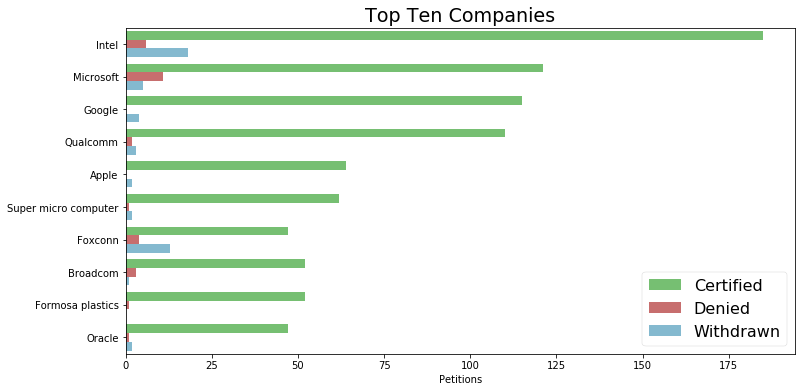

In [13]:
top_c = perm.Employer.value_counts().sort_values(ascending=False).head(10).index
f, ax = plt.subplots(figsize=(12, 6))

sns.countplot(y="Employer",
              hue='Status',
              data=perm.loc[perm.Employer.isin(top_c)],
              order = top_c,
              palette=["C1", "C2", "C5"],
              ax = ax
             );
sns.set_context("poster")
plt.legend(loc=4)
ax.set(title='Top Ten Companies', ylabel='', xlabel='Petitions');

### And the top ten States:

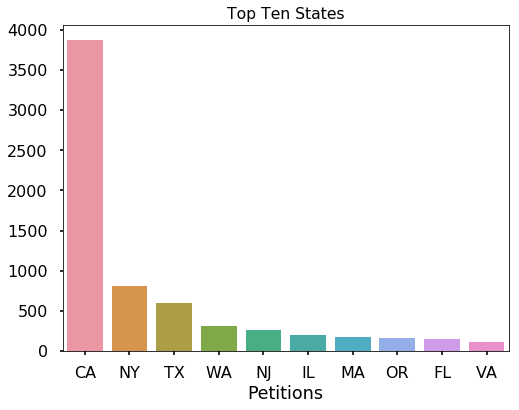

In [14]:
top_s = perm.State.value_counts().sort_values(ascending=False).head(10).index
f, ax = plt.subplots(figsize=(8, 6))

sns.countplot(x="State",
              data=perm.loc[(perm.State.isin(top_s)) & (perm.Status=='Certified')],
              order = top_s,
              ax = ax
             );
sns.set_context("talk")
ax.set(title='Top Ten States', ylabel='', xlabel='Petitions');

#### Seems like most of the cases are from California, find out the percentage:

In [15]:
state_names = pd.read_csv('data/State_list.csv', names=['post','State'], index_col='post')

state_count = perm.State.value_counts().to_frame(name='Count')
state_count['Percent'] = 100*(state_count.Count/perm.State.value_counts().sum())
state_count['Cum %'] = 100*state_count.Count.cumsum()/state_count.Count.sum()
state_count = pd.concat([state_count, state_names], axis=1)

top_10 = state_count[['State', 'Count', 'Percent','Cum %']].sort_values(by='Count',ascending=False)   \
                                                           .round(2)                                  \
                                                           .head(10)
top_10.index = np.arange(1, 11)
top_10

,State,Count,Percent,Cum %
1,California,4313,48.06,48.06
2,New York,937,10.44,58.50
3,Texas,667,7.43,65.93
4,Washington,348,3.88,69.81
5,New Jersey,303,3.38,73.18
6,Illinois,232,2.58,75.77
7,Massachusetts,201,2.24,78.01
8,Oregon,183,2.04,80.04
9,Florida,173,1.93,81.97
10,Virginia,133,1.48,83.45


#### Nearly 60% of the cases are from California and New York, look into case status by the most two popular areas:

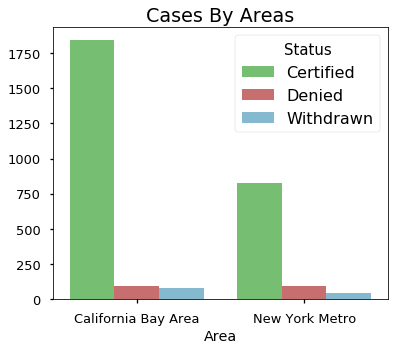

In [16]:
f, ax = plt.subplots(figsize=(6, 5))
sns.set_context("poster")
sns.countplot(data=perm,
              x='Area',
              hue='Status',
              palette=["C1", "C2", "C5"],);
ax.set(title='Cases By Areas', ylabel='');

#### Within approved cases in these two areas, what's the most populat job categories?

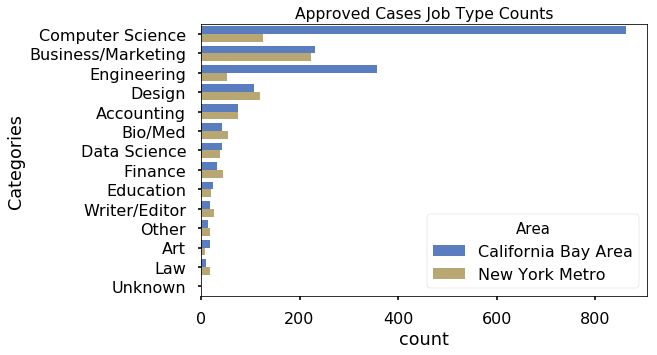

In [17]:
f, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=perm.loc[perm.Status=='Certified'],
              y="Cat",
              hue='Area',
              order = perm.loc[perm.Area.notnull(),'Cat'].value_counts().index,
              palette=["C0", "C4"],
              ax = ax);
sns.set_context("talk")
ax.set(title='Approved Cases Job Type Counts', ylabel='Categories');

#### Computer Science jobs dominate the approved cases

---
## Salary
#### descriptive statistics 

In [18]:
perm.groupby('Status')[['Salary']].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)

Salary                                                
           count      mean   median       std      min       max
Status                                                          
Certified   7972  75143.40  71292.0  30191.26  14726.0  315000.0
Denied       588  65781.55  60541.3  27445.41  12708.8  230000.0
Withdrawn    415  72603.74  68931.0  31842.28  12000.0  240000.0

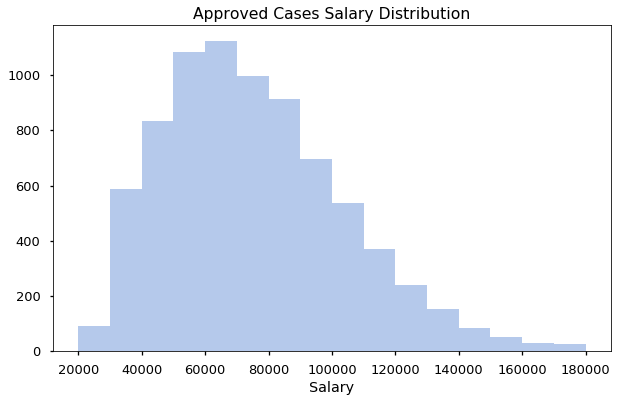

In [19]:
f, ax = plt.subplots(figsize=(10, 6))
sns.distplot(perm.loc[perm.Status=='Certified', 'Salary'],
             kde=False,
             bins=list(range(20000,190000,10000)))
ax.set(title='Approved Cases Salary Distribution');

#### The median salary of approved cases is \$ 71,292, which match the median annual household income for householders with a bachelor's degree or higher (\$ 72,376), cccording to the __[US Census Bureau](https://en.wikipedia.org/wiki/Household_income_in_the_United_States)__.

### Differences between job categories:

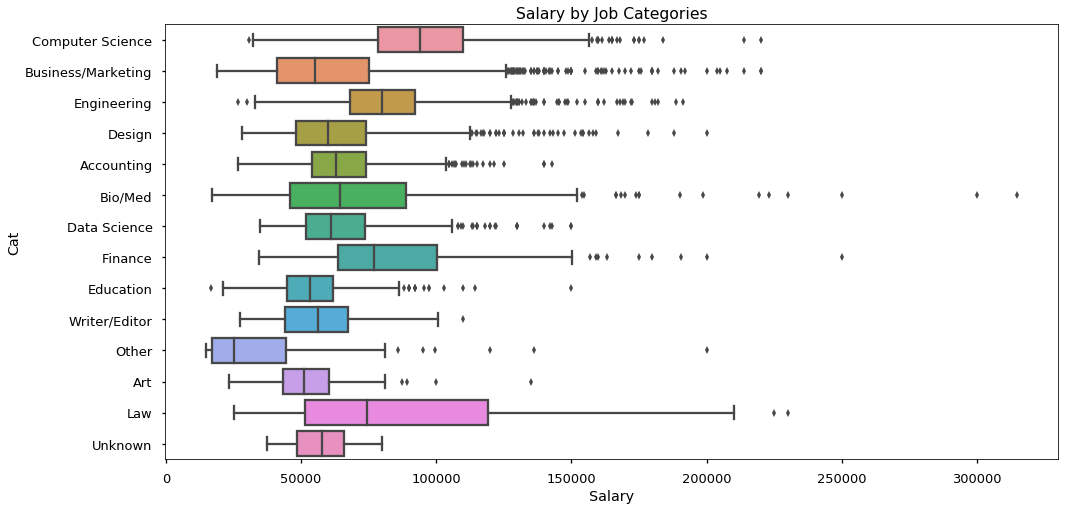

In [20]:
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(y="Cat",
            x="Salary",
            order = perm.loc[perm.Area.notnull(),'Cat'].value_counts().index,
            data=perm.loc[perm.Status=='Certified']);
ax.set(title='Salary by Job Categories');

## What about regional differences?

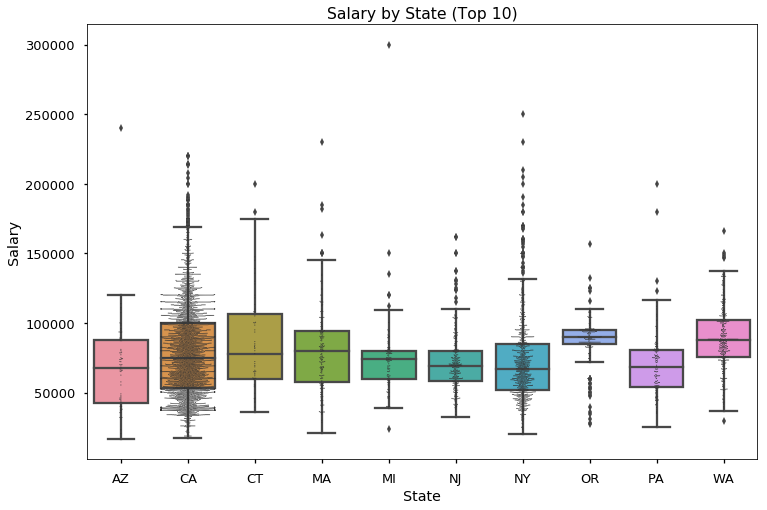

In [21]:
# not rare states
not_rare = perm.loc[perm.State.isin(perm.State.value_counts()[(perm.State.value_counts()>20)].index)].copy()
# top median
top_median = not_rare.groupby(['State'])['Salary'].agg('median').sort_values(ascending=False).head(10).index

top_df = perm.loc[perm.State.isin(top_median)].copy()
top_df.State = top_df.State.astype('object').astype('category')

f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x="State",
            y="Salary",
            data=top_df);
sns.swarmplot(x="State", 
              y="Salary", 
              data=top_df,
              size=1, 
              color=".2", 
              linewidth=0)
ax.set(title='Salary by State (Top 10)');

### Oregon have the highist average salary. Why? 
Intel filed the most petitions from October 2007 to March 2017. Intel has a global center of semiconductor research and manufacturing complex site located 30 minutes from downtown Portland, Oregon.

---

### By the way, who is this person?

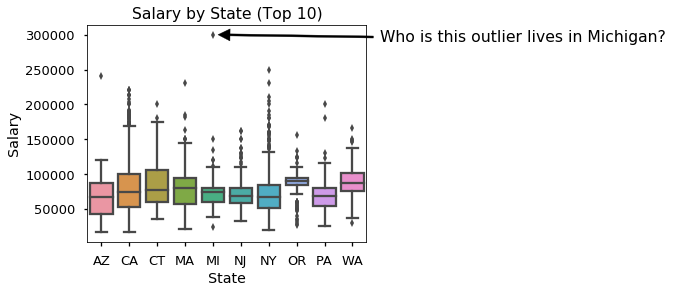

In [22]:
f, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(x="State",
            y="Salary",
            data=top_df);
plt.annotate('Who is this outlier lives in Michigan?', 
             xy=(4, 300000), 
             xytext=(10, 290000),
             arrowprops=dict(facecolor='black', shrink=0.03, width=2))
ax.set(title='Salary by State (Top 10)');

In [23]:
perm.loc[(perm.State =='MI') & (perm.Salary > 250000)]

,Date,Employer,Status,City,State,Area,Expired,Salary,Level,Title,Cat
5481,2010-10-27,Saint mary's healt,Certified,Grand rapids,MI,NaN,Yes,300000.0,1,"Physicians And Surgeons, All Other",Bio/Med


In [24]:
# ANOVA breakdown of Salary by States
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import statsmodels.api as smt
from statsmodels.formula.api import ols

model=ols('Salary ~ C(State)', data=top_df).fit()
print(smt.stats.anova_lm(model, typ=2))

                sum_sq      df          F        PR(>F)
C(State)  1.263952e+11     9.0  15.683084  1.164880e-25
Residual  5.956743e+12  6652.0        NaN           NaN


In these results, the null hypothesis states that the mean salary of 10 different states are equal. Because the p-value is less than the significance level of 0.01, we can reject the null hypothesis and conclude that some of the states have different average salary.

#### Differences between Bay area and New York Metro area:

In [25]:
perm.loc[perm.Status=='Certified'].groupby('Area')[['Salary']] \
                                  .agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)

Salary                                               
                     count      mean   median      std      min       max
Area                                                                     
California Bay Area   1840  95694.40  95631.5  29578.1  17014.4  220251.0
New York Metro         828  73077.64  67340.0  29434.8  23483.0  250000.0

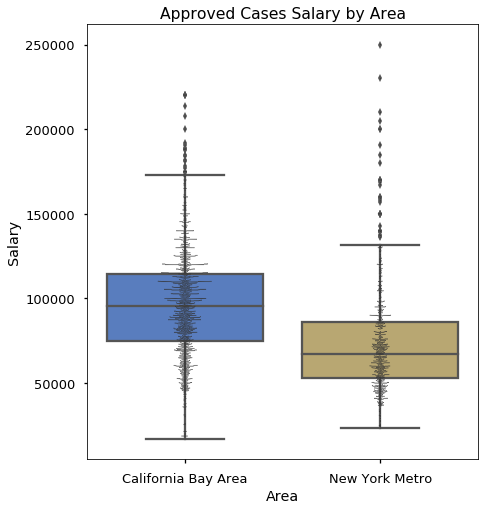

In [26]:
f, ax = plt.subplots(figsize=(7, 8))
sns.boxplot(x="Area",
            y="Salary",
            palette=["C0", "C4"],
            data=perm.loc[perm.Status=='Certified']);
sns.swarmplot(x="Area", 
              y="Salary", 
              data=perm.loc[perm.Status=='Certified'],
              size=1, 
              color=".2", 
              linewidth=0)
ax.set(title='Approved Cases Salary by Area');

### California has higher average  salary, but more outliers in New York (in finance and legal industry)

In [27]:
perm.loc[(perm.Area =='New York Metro') & (perm.Salary > 200000)]

,Date,Employer,Status,City,State,Area,Expired,Salary,Level,Title,Cat
2990,2014-01-10,Jp morgan chase & co,Certified,New york,NY,New York Metro,Yes,250000.0,4,"Securities, Commodities, And Financial Service...",Finance
3859,2012-08-02,White & case,Certified,New york,NY,New York Metro,No,230000.0,2,Lawyers,Law
4409,2011-12-01,T3 trading group,Certified,New york,NY,New York Metro,Yes,204984.0,4,Lawyers,Law
7843,2008-04-14,Reed smith,Certified,New york,NY,New York Metro,No,210000.0,2,Lawyers,Law


In [28]:
# Two-sample t-test for average salary in california bay area and new york metro area:
from scipy.stats import ttest_ind

bay = perm.loc[(perm.Status=='Certified') & (perm.Area == 'California Bay Area')]
nym = perm.loc[(perm.Status=='Certified') & (perm.Area == 'New York Metro')] 

results = ttest_ind(bay.Salary, nym.Salary)
print('t-statistic: ' + str(results[0]))
print('p-value:     ' + str(results[1]))

t-statistic: 18.2996811794
p-value:     1.45658653945e-70


In this result, the null hypothesis states that the mean salary of two areas are equal. Because the p-value is less than the significance level of 0.01, we can reject the null hypothesis and conclude that the average salary in Bay area is significantly higher than New York Metro area.

#### Differences between job levels:

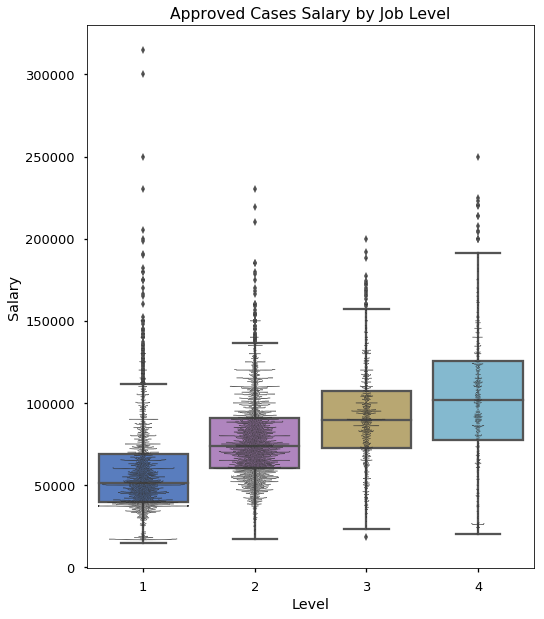

In [29]:
f, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(x="Level",
            y="Salary",
            order = ['1','2','3','4'],
            palette=["C0", "C3","C4","C5"],
            data=perm.loc[perm.Status=='Certified']);
sns.swarmplot(x="Level", 
              y="Salary",
              order = ['1','2','3','4'], 
              data=perm.loc[perm.Status=='Certified'],
              size=1, 
              color=".2", 
              linewidth=0)
ax.set(title='Approved Cases Salary by Job Level');

In [30]:
# ANOVA breakdown of Salary by job levels
model=ols('Salary ~ C(Level)', data=top_df).fit()
print(smt.stats.anova_lm(model, typ=2))

                sum_sq      df           F  PR(>F)
C(Level)  1.223778e+12     3.0  570.143529     0.0
Residual  4.490351e+12  6276.0         NaN     NaN


In these results, the null hypothesis states that the mean salary of 4 different job level are equal. Because the p-value is less than the significance level of 0.01, we can reject the null hypothesis and conclude that average salary difference between job levels is statistical significant.

#### Differences between job levels and areas:

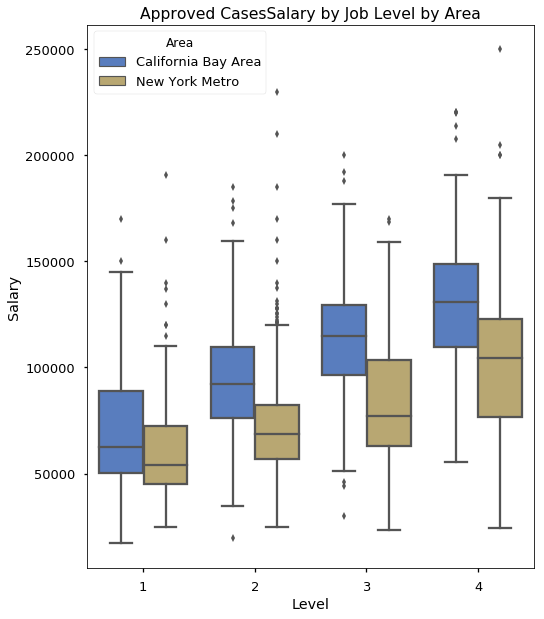

In [31]:
f, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(x="Level",
            y="Salary",
            hue='Area',
            palette=["C0", "C4"],
            order = ['1','2','3','4'],
            data=perm.loc[perm.Status=='Certified']);
ax.set(title='Approved CasesSalary by Job Level by Area');

#### At level 3, the average salary difference is the biggest

In [32]:
# ANOVA breakdown of Salary by Level and area
model=ols('Salary ~ C(Level) + C(Area)', data=perm.loc[perm.Status=='Certified']).fit()
print(smt.stats.anova_lm(model, typ=2))

                sum_sq      df           F         PR(>F)
C(Level)  4.975960e+11     3.0  235.906884  1.773966e-134
C(Area)   2.052291e+11     1.0  291.893212   6.379670e-62
Residual  1.724696e+12  2453.0         NaN            NaN


In these results, the null hypothesis states that the mean salary between different job level and Area are equal. Because the p-value is less than the significance level of 0.01, we can reject the null hypothesis and conclude that average salary difference between job levels and areas is statistical significant.

#### Differences between job levels and case status:

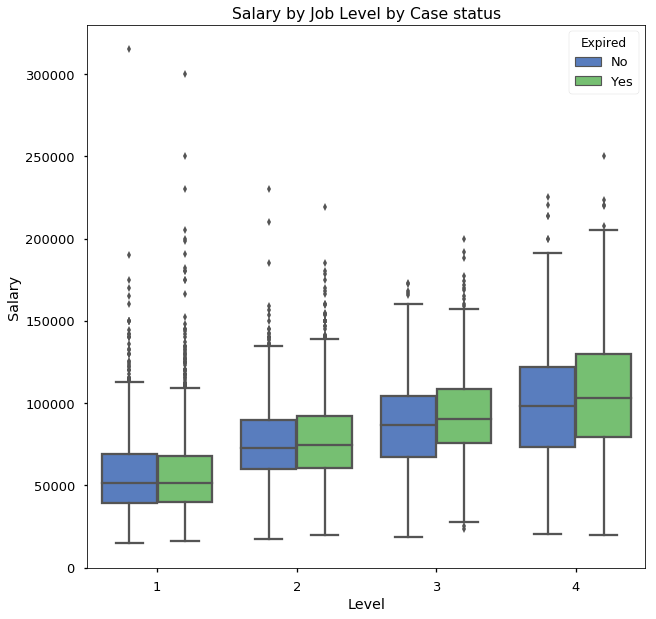

In [33]:
f, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="Level",
            y="Salary",
            hue='Expired',
            order = ['1','2','3','4'],
            data=perm.loc[perm.Status=='Certified']);
ax.set(title='Salary by Job Level by Case status');

In [34]:
# ANOVA breakdown of Salary by Level and Expiration

model=ols('Salary ~ C(Level) + C(Expired)', data=perm.loc[perm.Status=='Certified']).fit()
print(smt.stats.anova_lm(model, typ=2))

                  sum_sq      df           F    PR(>F)
C(Level)    1.373687e+12     3.0  632.582116  0.000000
C(Expired)  3.743197e+09     1.0    5.171221  0.022992
Residual    5.500550e+12  7599.0         NaN       NaN


In these results, because of the p-value of 'Level' is less than the significance level of 0.01, and the p-value of 'Expired' is geater than the significance level of 0.01, we can conclude that the average salary difference between job levels is statistical significant, but not between expiration status.

---
## Salary Trend

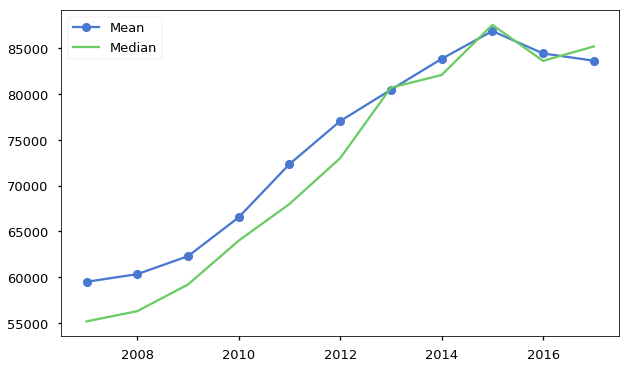

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(perm.loc[perm.Status=='Certified'].groupby(perm.Date.dt.year)['Salary']
         .agg(['mean']), marker='o', label='Mean')
plt.plot(perm.loc[perm.Status=='Certified'].groupby(perm.Date.dt.year)['Salary']
         .agg(['median']), label='Median')
plt.legend();

#### Salary trend by area

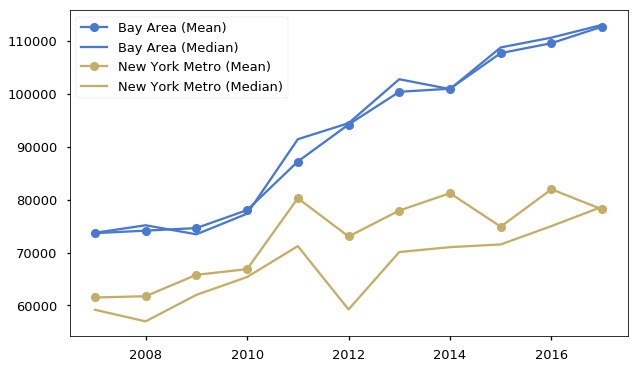

In [36]:
plt.figure(figsize=(10, 6))
perm_cer = perm.loc[perm.Status=='Certified']  
data = perm_cer.groupby([perm_cer.Date.dt.year, perm_cer.Area])['Salary'].agg(['mean','median']).unstack(level=-1)
plt.plot(data['mean']['California Bay Area'], marker='o', label='Bay Area (Mean)',color='C0')
plt.plot(data['median']['California Bay Area'], label='Bay Area (Median)',color='C0')
plt.plot(data['mean']['New York Metro'], marker='o', label='New York Metro (Mean)',color='C4')
plt.plot(data['median']['New York Metro'], label='New York Metro (Median)',color='C4')
plt.legend();

#### Difference in average salary increased after 2011

---
## Multiple Regression (OLS)
### Fitting a model to see how accurately job level, area, job category and year can explain actual salaries. 

In [37]:
# focus on only Bay area and New York Metro area
reg_df = perm.loc[perm.Area.notnull()].copy()
reg_df['Year'] = reg_df.Date.dt.year

model=ols('Salary ~ C(Level)+C(Area)+C(Cat)+C(Year)+C(Level)*C(Area)', data=reg_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     105.8
Date:                Sat, 20 Jan 2018   Prob (F-statistic):               0.00
Time:                        14:40:06   Log-Likelihood:                -31214.
No. Observations:                2740   AIC:                         6.249e+04
Df Residuals:                    2709   BIC:                         6.267e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                4.714e+04   3332.952     14.142      0.000    4.06e+04    5.37e+04
C(Level)[T.2]                            1.654e+04   1453.764     11.377      0.000    1.37e+04    1.94e+04
C(Level)[T.3]                            3.373e+04   1921.980     17.552      0.000       3e+04    3.75e+04
C(Level)[T.4]                            4.965e+04   2267.761     21.892      0.000    4.52e+04    5.41e+04
C(Area)[T.New York Metro]               -3772.6585   1814.593     -2.079      0.038   -7330.785    -214.532
C(Cat)[T.Art]                           -1.464e+04   4084.661     -3.584      0.000   -2.27e+04   -6631.950
C(Cat)[T.Bio/Med]                        -874.9461   2745.080     -0.319      0.750   -6257.609    4507.716
C(Cat)[T.Business/Marketing]             3295.8037   1961.315      1.680      0.093    -550.021    7141.628
C(Cat)[T.Computer Science]               2.391e+04   1846.296     12.949      0.000    2.03e+04    2.75e+04
C(Cat)[T.Data Science]                   1.228e+04   2880.358      4.265      0.000    6636.530    1.79e+04
C(Cat)[T.Design]                         -156.0555   2137.852     -0.073      0.942   -4348.041    4035.930
C(Cat)[T.Education]                     -1.811e+04   3383.775     -5.352      0.000   -2.47e+04   -1.15e+04
C(Cat)[T.Engineering]                     1.31e+04   2010.474      6.516      0.000    9157.078     1.7e+04
C(Cat)[T.Finance]                        3.315e+04   2930.180     11.314      0.000    2.74e+04    3.89e+04
C(Cat)[T.Law]                            4.123e+04   4232.532      9.741      0.000    3.29e+04    4.95e+04
C(Cat)[T.Other]                         -2.385e+04   3857.879     -6.183      0.000   -3.14e+04   -1.63e+04
C(Cat)[T.Unknown]                        1.316e+04   2.17e+04      0.607      0.544   -2.93e+04    5.57e+04
C(Cat)[T.Writer/Editor]                 -1.082e+04   3361.879     -3.220      0.001   -1.74e+04   -4232.065
C(Year)[T.2008]                          2909.0485   3035.531      0.958      0.338   -3043.142    8861.239
C(Year)[T.2009]                          3165.7236   2950.128      1.073      0.283   -2619.006    8950.453
C(Year)[T.2010]                          6687.5292   2809.801      2.380      0.017    1177.959    1.22e+04
C(Year)[T.2011]                          1.388e+04   2957.693      4.692      0.000    8077.191    1.97e+04
C(Year)[T.2012]                          1.259e+04   2926.989      4.300      0.000    6847.135    1.83e+04
C(Year)[T.2013]                          1.417e+04   3266.108      4.338      0.000    7765.685    2.06e+04
C(Year)[T.2014]                          1.769e+04   2907.894      6.082      0.000     1.2e+04    2.34e+04
C(Year)[T.2015]                          1.987e+04   2853.2

An Adjusted R-Squared value of 0.535 would indicate that the model explains approximately 54% of the variation in the dependent variable (Salary). Coefficients above represent the mean change in the response variable for one unit of change, in this model all independent variables are categorical data, so the cooefficient for those dummy variables(one or zero) are either included or not.
Finally, let's see how good is this model by comparing predition and actual salary in the data.

In [38]:
predictions = model.predict(reg_df[['Level','Area','Cat','Year']]).rename('Predicted Salary')
reg_df = reg_df.join(predictions)

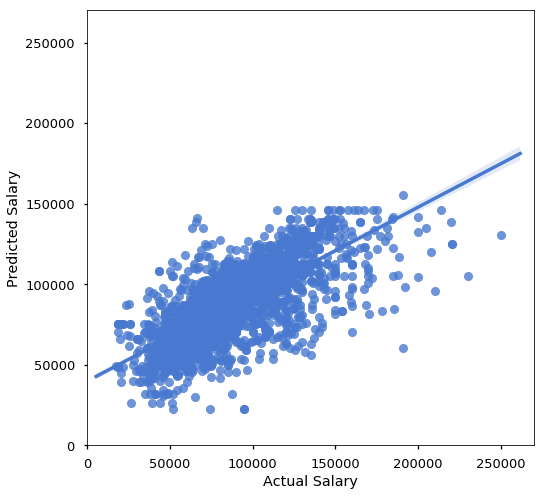

In [39]:
plt.figure(figsize=(8, 8))
sns.regplot(x="Salary", y="Predicted Salary", data=reg_df);
plt.xlabel('Actual Salary');
plt.xlim(0, 270000);
plt.ylim(0, 270000);

A better model will have a 45 degree regression line with y intercept equals to 0. <br>
With an Adjusted R-Squared value of 0.535, there are still many variables need to be considered when we trying to understand the variation in salary.

---

# See __[Summary Report](http://www.ktcdata.com/tw_perm/)__

# What do you think about this analysis?
__Please don't hesitate to contact me if you have any comments/suggestions.__ <br>
__Kuang-Ting Chang__<br>
e-mail: ktc312@nyu.edu<br>
website: __[www.ktcdata.com](http://www.ktcdata.com)__